Importing useful libraries and importing the drive for the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import torch
import torch.nn as nn
import sklearn
import pandas as pd
import io
import math
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


Importing the data

In [3]:
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [4]:
pddata = pddata.to_numpy()
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

Some helpers function for the analysis below

In [5]:
def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

In [6]:
from sklearn import preprocessing

def standardize(x):
  scaler = preprocessing.StandardScaler().fit(training_data)
  x = scaler.transform(x)
  return x

In [7]:
def split_RelKa(y, p):
  return np.array([1 if value > p else 0 for value in y])

In [8]:
from sklearn.ensemble import RandomForestClassifier

def predict_with_Random_Forests(x_train, x_test, y_train, y_test):
  clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)  
  return y_pred

In [9]:
from sklearn import metrics

def return_accuracy(y_test, y_pred, verbose=1):
  C = metrics.confusion_matrix(y_test, y_pred)
  accuracy = np.trace(C) / len(y_test)
  if verbose == 1:
    print("The number of true negatives is:", C[0, 0])
    print("The number of false negatives is:", C[1,0])
    print("The number of false positives is:", C[0,1])  
    print("The number of true positives is:", C[1,1])
    print("The accuracy is:", accuracy)
  return accuracy

In [12]:
def split_outliers(threshold, scores):
  """
  As a consequence of the histogram below, we change the decision function 
  implemented in the isolation forests if the 
  Anomaly_Detection_Isolation_Forests function is told to do so
  """
  outliers_indices = np.where(scores <= threshold)[0]
  return outliers_indices

WE FIRTS TRY TO DO A PREDICTION WITHOUT ANY OUTLIER REMOTION TO HAVE A COMPARISON

In [10]:
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, train_size=0.7, random_state=42)

In [11]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 50428
The number of false negatives is: 253
The number of false positives is: 58
The number of true positives is: 436
The accuracy is: 0.9939228138739619


We see that indeed we get a very high accuracy and the number of FN is controlled. What if we finetune the parameters of the RF?

In [32]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 120, num = 5)]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 4, verbose=10)
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 1/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.993 total time= 3.9min
[CV 2/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 2/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.993 total time= 4.0min
[CV 3/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 3/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.992 total time= 4.0min
[CV 4/4; 1/3] START min_samples_leaf=1, min_samples_split=5, n_estimators=110...
[CV 4/4; 1/3] END min_samples_leaf=1, min_samples_split=5, n_estimators=110;, score=0.993 total time= 4.1min
[CV 1/4; 2/3] START min_samples_leaf=2, min_samples_split=8, n_estimators=100...
[CV 1/4; 2/3] END min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.993 total tim

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=3,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 105, 110, 115,
                                                         120]},
                   verbose=10)

In [36]:
clf = RandomForestClassifier(n_estimators=110, min_samples_leaf=2, min_samples_split=5, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 46447
The number of false negatives is: 263
The number of false positives is: 36
The number of true positives is: 408
The accuracy is: 0.9936590745217797


We see that the accuracy with respect to the above (0.9939228138739619) is 
indeed decreasing a little bit (0.9936590745217797)

ISOLATION FORESTS ANOMALY DETECTION

In [26]:
from sklearn.ensemble import IsolationForest

def Anomaly_Detection_Isolation_Forests(x, change_split=True):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

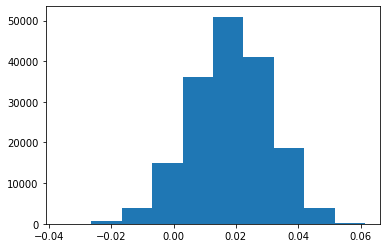

The indecision percentage around 0.02 is 0.5964638817137258
The percentage of outliers detected is 0.07785906634829187


In [27]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(training_data, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [23]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, train_size=0.7, random_state=42)

In [25]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 46443
The number of false negatives is: 250
The number of false positives is: 40
The number of true positives is: 421
The accuracy is: 0.993849938499385


THE RESULTS ARE COLLECTED HERE: BY CHANGING THE SPLITTING OF THE OUTLIERS \\
The number of true negatives is: 50393 \\
The number of false negatives is: 262 \\
The number of false positives is: 51 \\
The number of true positives is: 429 \\
The accuracy is: 0.9938789478830546

WHILE BY MAINTAINING THE STANDARD ISOLATION FORESTS ALGORITHM \\
The number of true negatives is: 46443 \\
The number of false negatives is: 250 \\
The number of false positives is: 40 \\
The number of true positives is: 421 \\
The accuracy is: 0.993849938499385 

GIVING US THE CONFIRMATION THAT DROPPING OUTLIERS IS NOT CONVENIENT HERE



We see that we have a problem with a large number of false negatives, namely with incorrectly predictions of the negative class

A further insight on the errors has to be done, but probably increasing the threshold 0.5 helps already a lot

# CROSS VALIDATION (5-FOLD) TO FINETUNE THE RF PARAMETERS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, train_size=0.7, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=10)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 1/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.5min
[CV 2/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 2/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time= 1.6min
[CV 3/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 3/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.6min
[CV 4/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 4/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.6min
[CV 5/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 5/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 tot

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   verbose=10)

In [ ]:
clf = RandomForestClassifier(n_estimators=150, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 117751
The number of false negatives is: 746
The number of false positives is: 101
The number of true positives is: 808
The accuracy is: 0.9929065541095088


We see that the accuracy is slightly decreasing with respect to the case in which the parameters were not tuned

LOCAL OUTLIER FACTOR ANOMALY DETECTION
The quickness here is really depending on the number of neighbours, for example
n_neigbors = 20 is already too much and Isolation Forests may be already considered preferable as they are quite efficient without incurring in large running times.


In [ ]:
from sklearn.neighbors import LocalOutlierFactor 

def LOF_Anomaly_Detection(X):
  clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', novelty=False)
  anomaly_score = clf.fit_predict(X)
  scores = clf.negative_outlier_factor(X)
  outliers_indices = np.where(anomaly_score == -1)[0]
  return scores, outliers_indices

In [ ]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, test_size=0.7, random_state=42)

In [ ]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)